# Clean Metadata
This notebook processes raw metadata provided by GISAID into the format required by Augur. Furthermore, it extracts additional information into unique variables.

## Setup

### Imports

In [1]:
import numpy as np
import pandas as pd
import plotnine as p9
import re

# Custom cleaning functions
from data.prep_data.clean_seqs import clean_strain_names
from data.prep_data.clean_seqs import deduplicate

### Files

#### Inputs

In [3]:
input_gisaid = 'h3n2/data/raw/africa_Jun2018_Now.xls'

#### Outputs



In [2]:
export_augur = 'h3n2/data/clean/africa_clean.tsv'

### Parameters

## Load raw data from GISAID

In [4]:
meta_raw = pd.DataFrame(pd.read_excel(input_gisaid))
meta_raw.head()

,Isolate_Id,PB2 Segment_Id,PB1 Segment_Id,PA Segment_Id,HA Segment_Id,NP Segment_Id,NA Segment_Id,MP Segment_Id,NS Segment_Id,HE Segment_Id,...,PB2 INSDC_Upload,PB1 INSDC_Upload,PA INSDC_Upload,HA INSDC_Upload,NP INSDC_Upload,NA INSDC_Upload,MP INSDC_Upload,NS INSDC_Upload,HE INSDC_Upload,P3 INSDC_Upload
0,EPI_ISL_320344,EPI1269115|3000822851_N8K9FDGB_v1_1,EPI1269116|3000822851_N8K9FDGB_v1_2,EPI1269114|3000822851_N8K9FDGB_v1_3,EPI1269118|3000822851_N8K9FDGB_v1_4,EPI1269111|3000822851_N8K9FDGB_v1_5,EPI1269117|3000822851_N8K9FDGB_v1_6,EPI1269113|3000822851_N8K9FDGB_v1_7,EPI1269112|3000822851_N8K9FDGB_v1_8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPI_ISL_320345,EPI1269123|3000822852_N8K9FDGG_v1_1,EPI1269124|3000822852_N8K9FDGG_v1_2,EPI1269122|3000822852_N8K9FDGG_v1_3,EPI1269126|3000822852_N8K9FDGG_v1_4,EPI1269119|3000822852_N8K9FDGG_v1_5,EPI1269125|3000822852_N8K9FDGG_v1_6,EPI1269121|3000822852_N8K9FDGG_v1_7,EPI1269120|3000822852_N8K9FDGG_v1_8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EPI_ISL_320349,EPI1269155|3000822795_N8K9FD8J_v1_1,EPI1269156|3000822795_N8K9FD8J_v1_2,EPI1269154|3000822795_N8K9FD8J_v1_3,EPI1269158|3000822795_N8K9FD8J_v1_4,EPI1269151|3000822795_N8K9FD8J_v1_5,EPI1269157|3000822795_N8K9FD8J_v1_6,EPI1269153|3000822795_N8K9FD8J_v1_7,EPI1269152|3000822795_N8K9FD8J_v1_8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EPI_ISL_336077,NaN,NaN,NaN,EPI1345964|MS-a-egypt-5730-2018h3S,NaN,EPI1345965|MS-a-egypt-5730-2018n2S,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EPI_ISL_336078,NaN,NaN,NaN,EPI1345966|MS-a-egypt-5816-2018h3S,NaN,EPI1345967|MS-a-egypt-5816-2018n2S,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Keep only the columns we are interested in.

In [5]:
retained_cols = [
    'Isolate_Name',
    'Collection_Date',
    'Isolate_Id',
    'Location',
    'Host',
    'Submitting_Lab',
    'Originating_Lab']

meta_working = meta_raw[retained_cols]

Standardize column name formatting:
- all lowercase
- underscore for word separation (already true)

In [6]:
meta_working.columns = [c.lower() for c in meta_working.columns]

Provide [required columns](https://docs.nextstrain.org/projects/ncov/en/wdl-optionals/analysis/data-prep.html#required-metadata) for Nextstrain.

In [7]:
meta_working = meta_working.rename(
    columns = {
        'isolate_name': 'strain',
        'collection_date': 'date'
    }
)
meta_working['virus'] = 'h3n2_flu'

In [8]:
meta_working.head(n=20)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus
0,A/Congo/416/2018,2018-07-05,EPI_ISL_320344,"Africa / Congo, the Democatic Republic of",Human,Centers for Disease Control and Prevention,INRB Service de Virologie,h3n2_flu
1,A/Congo/422/2018,2018-07-10,EPI_ISL_320345,"Africa / Congo, the Democatic Republic of",Human,Centers for Disease Control and Prevention,INRB Service de Virologie,h3n2_flu
2,A/Congo/357/2018,2018-06-14,EPI_ISL_320349,"Africa / Congo, the Democatic Republic of",Human,Centers for Disease Control and Prevention,INRB Service de Virologie,h3n2_flu
3,A/Egypt/5730/2018,2018-09-20,EPI_ISL_336077,Africa / Egypt,Human,Crick Worldwide Influenza Centre,Ministry of Health and Population,h3n2_flu
4,A/Egypt/5816/2018,2018-09-28,EPI_ISL_336078,Africa / Egypt,Human,Crick Worldwide Influenza Centre,Ministry of Health and Population,h3n2_flu
5,A/Egypt/6213/2018,2018-10-22,EPI_ISL_336079,Africa / Egypt,Human,Crick Worldwide Influenza Centre,Ministry of Health and Population,h3n2_flu
6,A/Kenya/155/2018,2018-07-17,EPI_ISL_336501,Africa / Kenya,Human,Centers for Disease Control and Prevention,CDC-Kenya,h3n2_flu
7,A/Kenya/156/2018,2018-07-23,EPI_ISL_336502,Africa / Kenya,Human,Centers for Disease Control and Prevention,CDC-Kenya,h3n2_flu
8,A/Kenya/157/2018,2018-07-24,EPI_ISL_336503,Africa / Kenya,Human,Centers for Disease Control and Prevention,CDC-Kenya,h3n2_flu
9,A/Kenya/158/2018,2018-07-30,EPI_ISL_336504,Africa / Kenya,Human,Centers for Disease Control and Prevention,CDC-Kenya,h3n2_flu


## Parse metadata

### Parse country

In [9]:
split_columns = meta_working['location'].str.split(' / ', expand=True)
meta_working['region'] = split_columns[0]
meta_working['country'] = split_columns[1]

In [10]:
meta_working.head(n=10)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus,region,country
0,A/Congo/416/2018,2018-07-05,EPI_ISL_320344,"Africa / Congo, the Democatic Republic of",Human,Centers for Disease Control and Prevention,INRB Service de Virologie,h3n2_flu,Africa,"Congo, the Democatic Republic of"
1,A/Congo/422/2018,2018-07-10,EPI_ISL_320345,"Africa / Congo, the Democatic Republic of",Human,Centers for Disease Control and Prevention,INRB Service de Virologie,h3n2_flu,Africa,"Congo, the Democatic Republic of"
2,A/Congo/357/2018,2018-06-14,EPI_ISL_320349,"Africa / Congo, the Democatic Republic of",Human,Centers for Disease Control and Prevention,INRB Service de Virologie,h3n2_flu,Africa,"Congo, the Democatic Republic of"
3,A/Egypt/5730/2018,2018-09-20,EPI_ISL_336077,Africa / Egypt,Human,Crick Worldwide Influenza Centre,Ministry of Health and Population,h3n2_flu,Africa,Egypt
4,A/Egypt/5816/2018,2018-09-28,EPI_ISL_336078,Africa / Egypt,Human,Crick Worldwide Influenza Centre,Ministry of Health and Population,h3n2_flu,Africa,Egypt
5,A/Egypt/6213/2018,2018-10-22,EPI_ISL_336079,Africa / Egypt,Human,Crick Worldwide Influenza Centre,Ministry of Health and Population,h3n2_flu,Africa,Egypt
6,A/Kenya/155/2018,2018-07-17,EPI_ISL_336501,Africa / Kenya,Human,Centers for Disease Control and Prevention,CDC-Kenya,h3n2_flu,Africa,Kenya
7,A/Kenya/156/2018,2018-07-23,EPI_ISL_336502,Africa / Kenya,Human,Centers for Disease Control and Prevention,CDC-Kenya,h3n2_flu,Africa,Kenya
8,A/Kenya/157/2018,2018-07-24,EPI_ISL_336503,Africa / Kenya,Human,Centers for Disease Control and Prevention,CDC-Kenya,h3n2_flu,Africa,Kenya
9,A/Kenya/158/2018,2018-07-30,EPI_ISL_336504,Africa / Kenya,Human,Centers for Disease Control and Prevention,CDC-Kenya,h3n2_flu,Africa,Kenya


## Clean dataframe
Clean up values.

Clean strain names
* strip leading and trailing whitespace
* replace spaces with underscores
* replace apostrophes with dashes

In [11]:
meta_working['strain'] = (
    meta_working['strain']
    .apply(lambda x: clean_strain_names(x))
)

In [12]:
meta_working.head(n=10)['strain']

0     A/Congo/416/2018
1     A/Congo/422/2018
2     A/Congo/357/2018
3    A/Egypt/5730/2018
4    A/Egypt/5816/2018
5    A/Egypt/6213/2018
6     A/Kenya/155/2018
7     A/Kenya/156/2018
8     A/Kenya/157/2018
9     A/Kenya/158/2018
Name: strain, dtype: object

### Deduplicate strains

In [13]:
meta_working = deduplicate(meta_working, 'strain')

Originally, there were 3375 records.
	There were 3081 unique records.
	After cleaning, there were 3081 records remaining.


### Clean up countries

In [14]:
meta_working['country'].value_counts(dropna=False)

country
South Africa                        793
Togo                                386
Kenya                               364
Zambia                              214
Cote d'Ivoire                       149
Niger                               129
Mali                                125
Congo, the Democatic Republic of    104
Madagascar                           90
Ghana                                84
Senegal                              78
Burkina Faso                         72
Nigeria                              72
Mauritius                            61
Cameroon                             58
Tunisia                              58
Mozambique                           50
Ethiopia                             41
Morocco                              32
Reunion                              30
Algeria                              27
Egypt                                18
Uganda                               12
Mayotte                              12
Mauritania                      

In [15]:
meta_working['country'] = (
    meta_working['country']
    .replace(
        {'Congo, the Democatic Republic of': 'DRC',
         'Tanzania, United Republic of': 'Tanzania'}
    ))

In [16]:
meta_working['country'].value_counts(dropna=False)

country
South Africa     793
Togo             386
Kenya            364
Zambia           214
Cote d'Ivoire    149
Niger            129
Mali             125
DRC              104
Madagascar        90
Ghana             84
Senegal           78
Burkina Faso      72
Nigeria           72
Mauritius         61
Cameroon          58
Tunisia           58
Mozambique        50
Ethiopia          41
Morocco           32
Reunion           30
Algeria           27
Egypt             18
Uganda            12
Mayotte           12
Mauritania         8
Tanzania           7
Seychelles         6
Gabon              1
Name: count, dtype: int64

## Export for Augur
Export tab-delimited file (TSV) for input into Augur.

- Replace `NaN` values with a question mark character (`?`), as preferred by Augur.
- Drop raw columns that have been parsed to new, expanded columns.
- Put columns in preferred order. This is not necessary for Augur, but provides a standard order for my own human reading.
- **Drop duplicate strains.**

In [17]:
col_order = [
    'strain',
    'date',
    'virus',
    'region', 
    'country',
    'host', 
    'isolate_id',
    'submitting_lab',
    'originating_lab']

meta_working = meta_working[col_order]

meta_clean = meta_working.fillna('?')

meta_clean.to_csv(export_augur, sep='\t', index=False, header=False)

## Plot and list all strains by country

### Plot strain counts by country

In [18]:
meta_clean['strain'].count()

3081

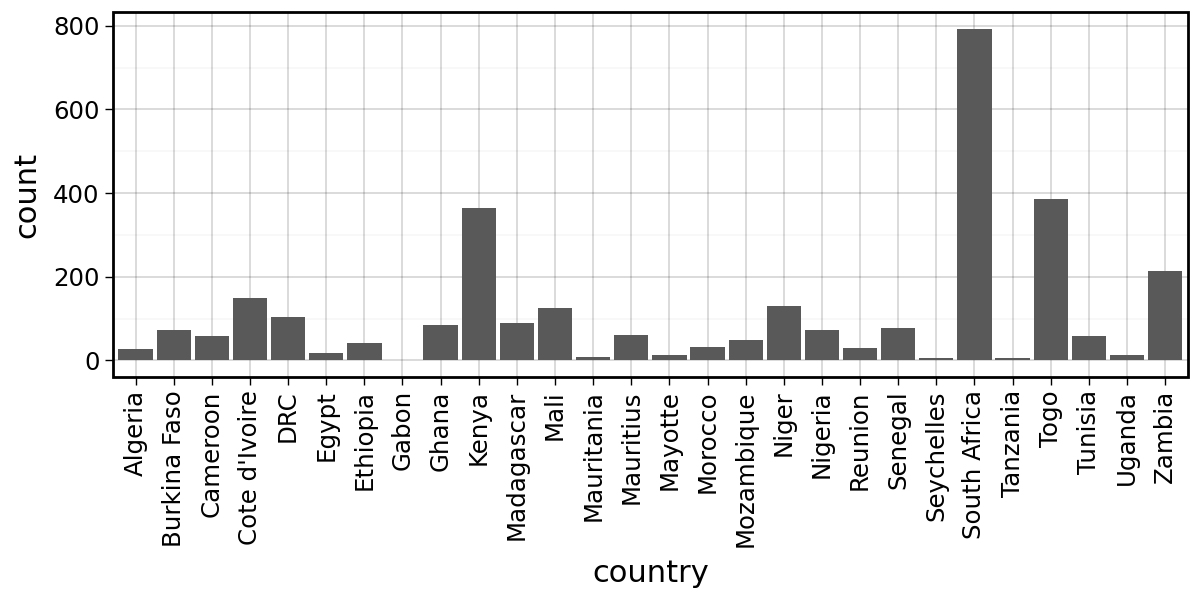

In [19]:
seqs_by_country = (
    p9.ggplot(meta_clean, p9.aes(x='country'))
    + p9.geom_bar()
    + p9.theme_linedraw()
    + p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5))  # Adjust hjust value here
    + p9.theme(figure_size=(6, 3))
)

seqs_by_country


### List strains by country

In [20]:
by_country = meta_working.groupby('country')['strain'].unique()
for key, value in by_country.items():
    print(f"{key} (n={len(value)})")
    for v in value:
        print(v)

Algeria (n=27)
A/Algiers/368/2020
A/Tiaret/282/2020
A/Blida/42154/2022
A/Algeria/Blida/42081/2022
A/Algeria/Tebessa/43091/2022
A/Algeria/Tebessa/43189/2022
A/Algeria/Tebessa/44013/2022
A/Algeria/Algiers/44334/2022
A/Algeria/Algiers/44342/2022
A/Algeria/Tebessa/44348/2022
A/Algeria/Tebessa/44354/2022
A/Algeria/Bouira/44511/2022
A/Algeria/27/2019
A/Algeria/38/2019
A/Algeria/45/2019
A/Algeria/55/2019
A/Algeria/2131/2023
A/Algeria/1767/2023
A/Algeria/1229/2023
A/Algeria/2157/2023
A/Algiers/92675/2021
A/Blida/93748/2021
A/Eph_Blida/97875/2021
A/Blida/90977/2021
A/Bouira/44511/2022
A/Boumerdes/44092/2022
A/Algiers/43409/2022
Burkina Faso (n=72)
A/Burkina_Faso/2405/2018
A/Burkina_Faso/972/2018
A/Burkina_Faso/2401/2018
A/Burkina_Faso/2406/2018
A/Burkina_Faso/2417/2018
A/Burkina_Faso/1035/2018
A/Burkina_Faso/2410/2018
A/Burkina_Faso/1042/2018
A/Burkina_Faso/1055/2018
A/Burkina_Faso/31/2019
A/Burkina_Faso/15/2019
A/Burkina_Faso/1/2019
A/Burkina_Faso/1767/2019
A/Burkina_Faso/1770/2019
A/Burkina_F